In [2]:
import funzioni as fx
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Bidirectional, BatchNormalization, LSTM, Dropout, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_addons as tfa

tot_ticker = 2000
bilanciamento = 1
batch_size = 1024
soglia = 0.5
class_weights = {0: 1, 1: 1}

X = np.load(f'dati/X_{tot_ticker}_{bilanciamento}.npy')
Y = np.load(f'dati/Y_{tot_ticker}_{bilanciamento}.npy')

print("Versione TensorFlow:", tf.__version__)
print("Versione CUDA:", tf.sysconfig.get_build_info()['cuda_version'])
print("Versione cuDNN:", tf.sysconfig.get_build_info()['cudnn_version'])
import psutil

def print_memory_usage():
    print(f"Memory usage: {psutil.virtual_memory().percent}%")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpu, 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("nessuna GPU")

Using TensorFlow backend


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning:



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning:

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and

Versione TensorFlow: 2.9.2
Versione CUDA: 11.2
Versione cuDNN: 8
1 Physical GPUs, 1 Logical GPUs


In [3]:
def crea_modello():
    model = Sequential()
    model.add(Bidirectional(LSTM(100, return_sequences=False), input_shape=(fx.n_timesteps, fx.n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # model.add(Dense(50, activation='relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=1, average='macro', threshold=soglia)])
    
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [reduce_lr, early_stopping]

model = crea_modello()  
history = model.fit(X, Y, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=callbacks, class_weight=class_weights)

2023-11-02 13:40:05.278579: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2317946400 exceeds 10% of free system memory.
2023-11-02 13:40:08.225760: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2317946400 exceeds 10% of free system memory.


Epoch 1/100
286/286 [==============================] - 15s 34ms/step - loss: 0.2878 - f1_score: 0.3901 - val_loss: 0.2037 - val_f1_score: 0.1396 - lr: 0.0010
Epoch 2/100
286/286 [==============================] - 7s 26ms/step - loss: 0.1908 - f1_score: 0.5399 - val_loss: 0.2136 - val_f1_score: 0.5787 - lr: 0.0010
Epoch 3/100
286/286 [==============================] - 8s 28ms/step - loss: 0.1779 - f1_score: 0.5636 - val_loss: 0.2173 - val_f1_score: 0.5804 - lr: 0.0010
Epoch 4/100
286/286 [==============================] - 7s 26ms/step - loss: 0.1730 - f1_score: 0.5727 - val_loss: 0.2001 - val_f1_score: 0.5980 - lr: 0.0010
Epoch 5/100
286/286 [==============================] - 8s 26ms/step - loss: 0.1684 - f1_score: 0.5819 - val_loss: 0.2217 - val_f1_score: 0.5826 - lr: 0.0010
Epoch 6/100
286/286 [==============================] - 7s 26ms/step - loss: 0.1656 - f1_score: 0.5868 - val_loss: 0.2295 - val_f1_score: 0.5788 - lr: 0.0010
Epoch 7/100
286/286 [==============================] - 8s

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              107200    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 108,201
Trainable params: 107,801
Non-trainable params: 400
_________________________________________________________________


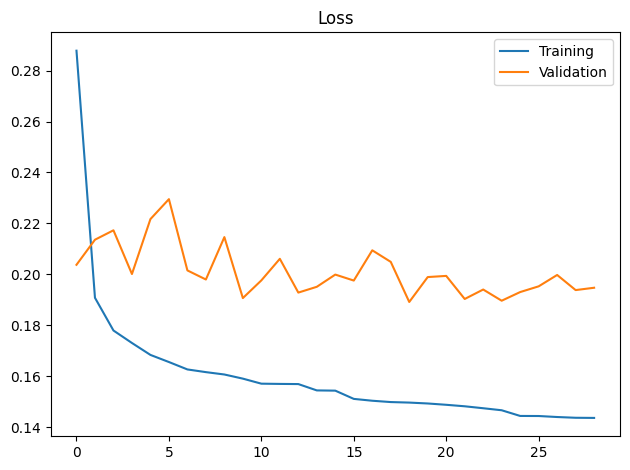

In [5]:
import matplotlib.pyplot as plt
model_history = pd.DataFrame(history.history)
num_epochs = model_history.shape[0]
plt.plot(np.arange(0, num_epochs), model_history['loss'], label="Training")
plt.plot(np.arange(0, num_epochs), model_history['val_loss'], label="Validation")
plt.legend()
plt.title('Loss')
plt.tight_layout()
plt.show()

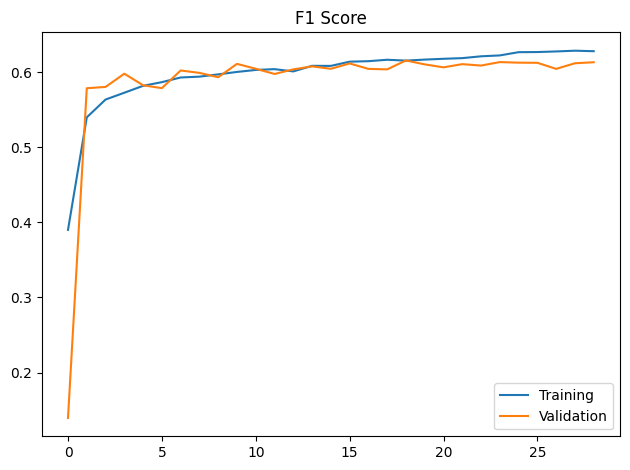

In [6]:
plt.plot(np.arange(0, num_epochs), model_history['f1_score'], label="Training")
plt.plot(np.arange(0, num_epochs), model_history['val_f1_score'], label="Validation")
plt.legend()
plt.title('F1 Score')
plt.tight_layout()
plt.show()

In [7]:
import yfinance as yf
ticker = yf.download("BTG", start='2010-01-01', end='2023-10-01', progress=True)
ticker.index = ticker.index.date
print("Calcolo indicatori ticker", flush=True)
ticker = fx.crea_indicatori(ticker)
ticker.dropna(axis=0, inplace=True)
print("Definizione features e target", flush=True)
idx, X, Y, scalers = fx.to_XY(ticker, fx.features_prezzo, fx.features_da_scalare_singolarmente, fx.features_meno_piu, fx.features_candele, fx.features_no_scala, fx.elenco_targets, fx.n_timesteps, 1, bilanciamento=0)
print(f'X.shape: {X.shape}')
print(f'Y.shape: {Y.shape}')
print(f'ticker.shape: {ticker.shape}')

[*********************100%%**********************]  1 of 1 completed
Calcolo indicatori ticker
Definizione features e target
X.shape: (3280, 60, 33)
Y.shape: (3280, 1)
ticker.shape: (3340, 49)


In [8]:
pred = model.predict(X, batch_size=batch_size, verbose=1, use_multiprocessing=True)
pred_binary = (pred > soglia).astype(int)
loss, metrics = model.evaluate(X, Y, batch_size=batch_size, verbose=1, use_multiprocessing=True, return_dict=True)


4/4 [==============================] - 0s 10ms/step - loss: 0.1532 - f1_score: 0.2698


In [9]:
pd.set_option('display.max_columns', None)
ris = pd.DataFrame(np.concatenate([Y, pred_binary], axis=1), columns=['Y', 'Prev'], index=idx)
ris = pd.merge(left=ris, right=ticker, how='left', left_index=True, right_index=True)
temp = ris[(ris['Prev'] == 1) & (ris['Y'] == 0)]
temp.tail(5)

,Y,Prev,Open,High,Low,Close,Adj Close,Volume,EMA_5,EMA_20,EMA_50,EMA_100,PSARaf,PSARr,PSAR,MACD,MACDh,MACDs,TSI,TSIs,SUPERT,SUPERTd,ADX,TRIX,TRIXs,AROONOSC,ATR,CMF,ROC_10,KVO,KVOs,VHF,OBV,Perc_Max_High_Futuro_20d,Perc_Drawdown_20d,EMA_20_5d,EMA_20_10d,EMA_20_15d,EMA_20_20d,EMA_50_5d,EMA_50_10d,EMA_50_15d,EMA_50_20d,Close_5d,Close_10d,Close_15d,Close_20d,DM_OSC,VTX_OSC,VI_OSC,Target
2022-11-10,0.0,1.0,3.45,3.56,3.43,3.53,3.368363,13440900,3.320615,3.174033,3.198355,3.341994,0.04,0,2.871384,-0.024322,0.040279,-0.064601,6.772429,-2.901029,3.020035,1,11.537832,-0.093118,-0.155304,100.0,0.162478,0.184824,12.420377,1.159358e+06,367565.607587,0.340426,-83794600.0,5.797103,5.217393,3.283107,3.353193,3.408877,3.391138,3.245355,3.283483,3.320614,3.328674,3.35,3.51,3.57,3.36,11.078311,0.260726,435.464836,False
2022-11-11,0.0,1.0,3.54,3.60,3.50,3.58,3.416073,14205800,3.407077,3.212697,3.213321,3.346707,0.06,0,2.898929,-0.000624,0.051181,-0.051805,10.894709,-0.930209,3.083783,1,12.130303,-0.050789,-0.140893,30.0,0.158015,0.229730,15.857606,1.381187e+06,512368.639887,0.383333,-69588800.0,3.107348,7.627118,3.293288,3.352889,3.411842,3.387220,3.251027,3.286092,3.325296,3.329511,3.39,3.35,3.44,3.35,12.008833,0.295302,436.881265,False
2023-03-17,0.0,1.0,3.55,3.69,3.52,3.66,3.574465,29426800,3.545372,3.493254,3.556763,3.554596,0.04,0,3.273464,-0.063509,0.017043,-0.080551,-5.381277,-15.174727,3.212483,1,15.117892,-0.297059,-0.336126,75.0,0.130958,0.078335,2.234641,8.996859e+05,-24937.415858,0.336000,-75289100.0,23.943666,0.000000,3.574674,3.728628,3.893057,4.040388,3.582063,3.651441,3.740481,3.836077,3.79,3.94,4.17,4.21,4.973279,0.219512,484.923159,False
2023-07-18,0.0,1.0,3.70,3.83,3.68,3.79,3.742327,6860200,3.701945,3.643650,3.712522,3.742172,0.08,0,3.544521,-0.068872,0.025622,-0.094494,-1.173039,-11.893938,3.463670,1,18.227075,-0.223947,-0.295261,60.0,0.115775,-0.103864,4.120875,9.728928e+04,10337.283468,0.238095,-28033000.0,3.243240,20.000000,3.643785,3.577339,3.422996,3.282991,3.700517,3.660603,3.575377,3.483359,3.66,3.39,3.12,3.04,4.089572,0.114035,465.511405,False
2023-07-19,0.0,1.0,3.78,3.82,3.74,3.75,3.702830,4800000,3.717963,3.653779,3.713992,3.742327,0.08,0,3.567359,-0.060213,0.027425,-0.087638,0.588519,-10.110730,3.463670,1,17.710918,-0.198986,-0.280432,60.0,0.113220,-0.091041,6.534091,1.865288e+05,35507.503911,0.255474,-32833000.0,-0.529100,21.693120,3.642472,3.550925,3.387472,3.257944,3.697751,3.646462,3.554774,3.465189,3.63,3.30,3.05,3.02,3.944223,0.209091,466.566813,False


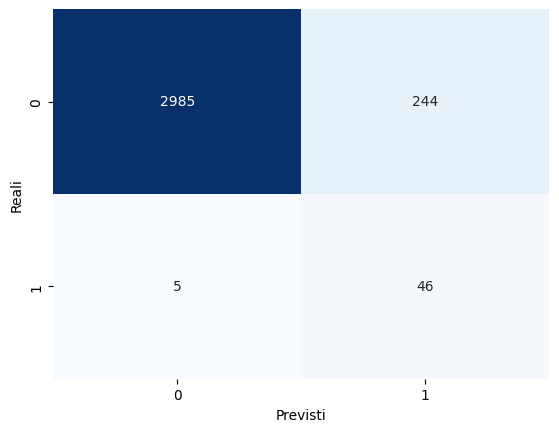

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
matrice = confusion_matrix(Y, pred_binary)

# Visualizza come heatmap
sns.heatmap(matrice, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsti')
plt.ylabel('Reali')
plt.show()

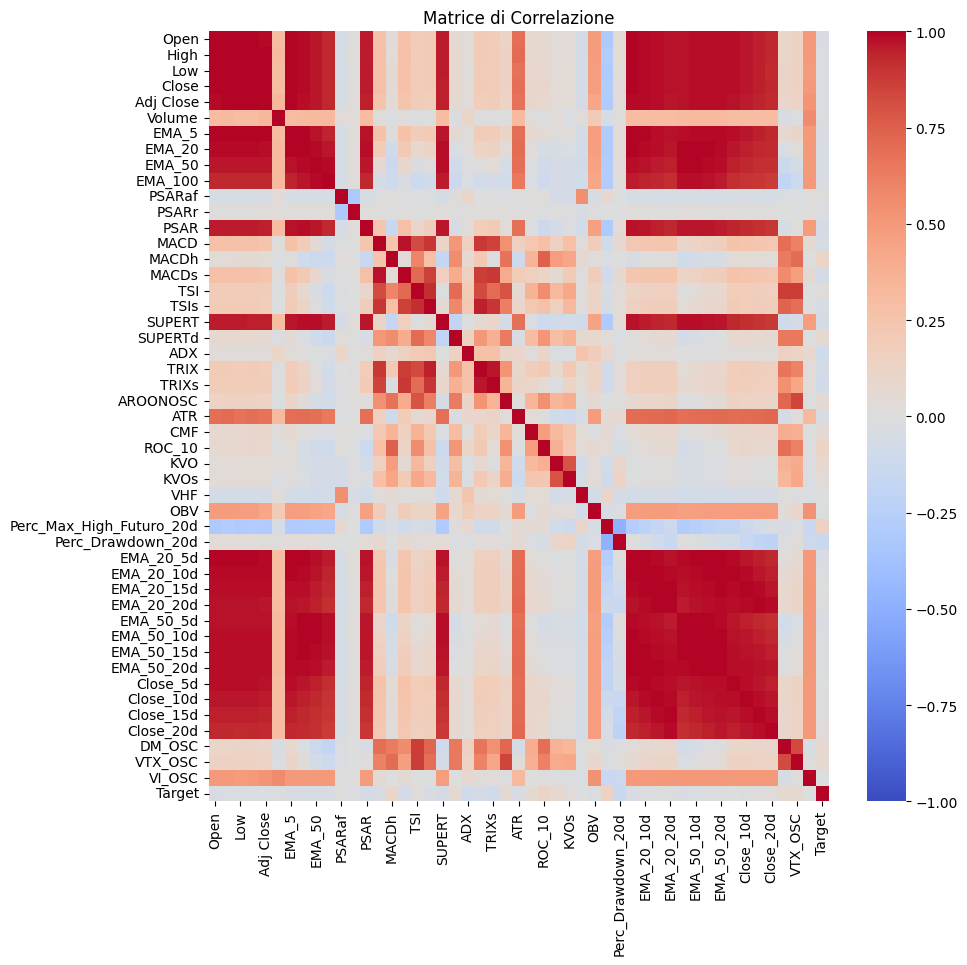

In [11]:
correlation_matrix = ticker.corr()
plt.figure(figsize=(10,10)) 
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice di Correlazione")
plt.show()